<a href="https://colab.research.google.com/github/syoung7388/Traffic_sign_recognition/blob/main/Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os 
import PIL
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader 
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
from torch import nn, optim
import torch.nn.functional as F


drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load the data

training_file = '/content/drive/MyDrive/Traffic/data/train.p'
validation_file = '/content/drive/MyDrive/Traffic/data/valid.p'
testing_file = '/content/drive/MyDrive/Traffic/data/test.p'

with open(training_file, mode = "rb") as f:
    train = pickle.load(f) # 파일을 로드함 
with open(validation_file, mode = "rb") as f:
    valid = pickle.load(f)
with open(testing_file, mode = "rb") as f:
    test = pickle.load(f) 
X_train, y_train = train['features'], train['labels'] 
X_valid, y_valid =  valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Number of training examples
n_train = len(X_train)
# Number of validation examples.
n_valid = len(X_valid)
# Number of testing examples.
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train[0].shape[:-1]

# Number of unique classes/labels in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


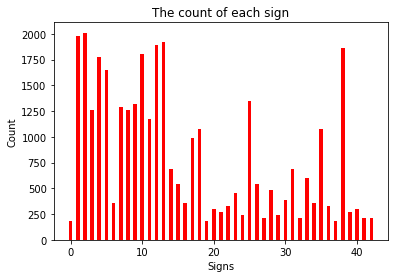

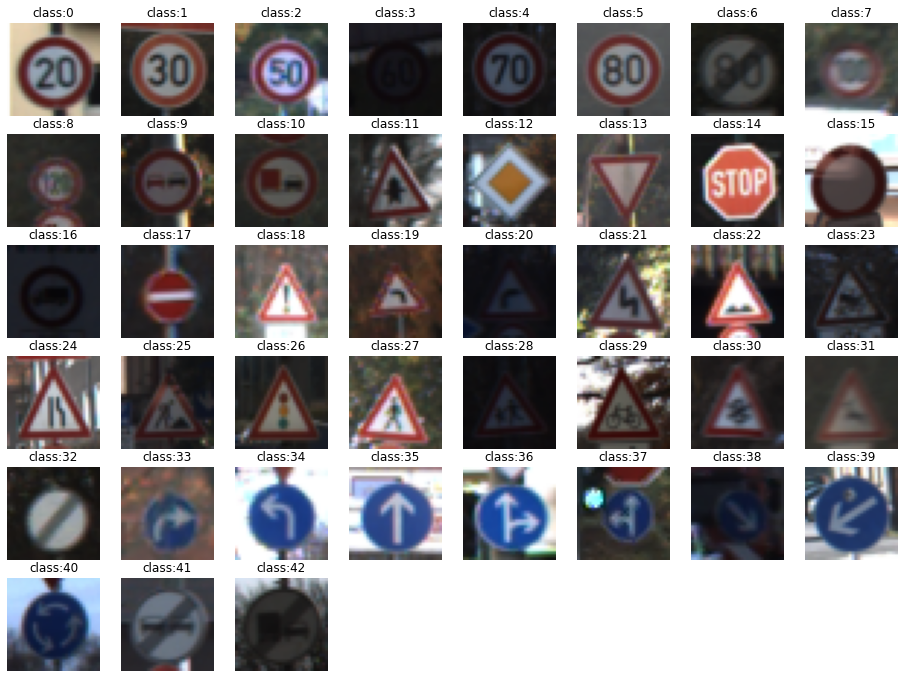

In [ ]:
# Data exploration visualization

flg, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(y_train), 0.5, color = 'r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()
plt.figure(figsize = (16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class:{}'.format(c))
    plt.imshow(X_train[i])


In [ ]:
# Design and Test a Baseline Mode

#Custom DataSet & DataLoader 
class PickledDataset(Dataset):
    def __init__(self, file_path, transform = None):
        with open(file_path, mode = 'rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])
    
    def __len__(self):
        return self.count
    
class WrappendDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))
    

In [ ]:
#BaseLine Model 
class BaselineNet(nn.Module):
    def __init__(self, gray = False):
        super(BaselineNet, self).__init__()
        input_chan = 1 if gray else 3
        self.conv1 = nn.Conv2d(input_chan, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Training

torch.manual_seed(1)

In [ ]:
train_dataset = PickledDataset(training_file, transform = transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform = transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform = transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def to_device(x, y):
    return x.to(device), y.to(device, dtype = torch.int64)

train_loader = WrappendDataLoader(train_loader, to_device)
valid_loader = WrappendDataLoader(valid_loader, to_device)
test_loader = WrappendDataLoader(test_loader, to_device)



In [ ]:
model = BaselineNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 20

In [ ]:
def loss_batch(model, loss_func, x, y, opt = None):
    loss = loss_func(model(x), y)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(x)
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim = 1)
    correct = pred == y.view(*pred.shape)
    return loss.item(), torch.sum(correct).item(), len(x)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        
        #Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        #Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums) / np.sum(nums))
            valid_accuracy = np.sum(corrects) / np.sum(nums)*100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")            
def evaluate(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100
        
    print(f"Test loss: {test_loss:.6f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")
    

In [ ]:
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.676078	Validation loss: 3.598375	 Validation accruacy: 5.306%
[Epoch 2/20] Train loss: 3.485026	Validation loss: 3.575990	 Validation accruacy: 5.442%
[Epoch 3/20] Train loss: 3.455557	Validation loss: 3.526577	 Validation accruacy: 7.347%
[Epoch 4/20] Train loss: 3.333797	Validation loss: 3.296682	 Validation accruacy: 19.002%
[Epoch 5/20] Train loss: 2.677617	Validation loss: 2.304653	 Validation accruacy: 39.138%
[Epoch 6/20] Train loss: 1.694676	Validation loss: 1.574378	 Validation accruacy: 56.667%
[Epoch 7/20] Train loss: 1.128311	Validation loss: 1.222312	 Validation accruacy: 64.921%
[Epoch 8/20] Train loss: 0.831300	Validation loss: 0.934510	 Validation accruacy: 72.880%
[Epoch 9/20] Train loss: 0.654083	Validation loss: 0.897814	 Validation accruacy: 74.717%
[Epoch 10/20] Train loss: 0.546803	Validation loss: 0.746406	 Validation accruacy: 79.410%
[Epoch 11/20] Train loss: 0.462285	Validation loss: 0.722711	 Validation accruacy: 80.476%
[Epoch 12/2

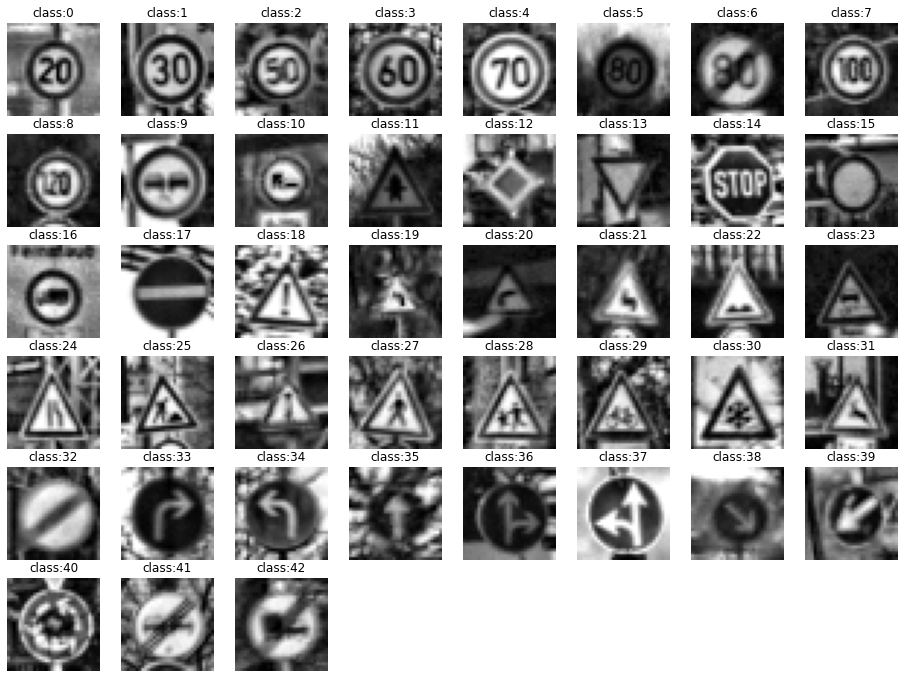

In [ ]:
# Experiment and find tuning
# Data preprocessing

class CLAHE_GRAY:
  def __init__(self, clipLimit = 2.5, tileGridSize = (4, 4)):
    self.clipLimit = clipLimit
    self.tileGridSize = tileGridSize
  def __call__(self, im):
    img_y = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)[:, :, 0]
    clahe = cv2.createCLAHE(clipLimit = self.clipLimit, tileGridSize = self.tileGridSize)
    img_y = clahe.apply(img_y)
    img_output = img_y.reshape(img_y.shape+(1,))
    return img_output

clahe = CLAHE_GRAY()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
  i = random.choice(np.where(y_train == c)[0])
  plt.subplot(8, 8, c+1)
  plt.axis('off')
  plt.title('class:{}'.format(c))
  plt.imshow(clahe(X_train[i]).squeeze(), cmap = 'gray')


In [ ]:
data_transforms = transforms.Compose([
    CLAHE_GRAY(), 
    transforms.ToTensor()
])

train_dataset = PickledDataset(training_file, transform = data_transforms)
valid_dataset = PickledDataset(validation_file, transform = data_transforms)
test_dataset = PickledDataset(testing_file, transform = data_transforms)

train_loader = WrappendDataLoader(DataLoader(train_dataset, batch_size = 64, shuffle = True), to_device)
valid_loader = WrappendDataLoader(DataLoader(valid_dataset, batch_size = 64, shuffle = False),to_device)
test_loader = WrappendDataLoader(DataLoader(test_dataset, batch_size = 64, shuffle = False),to_device)

model = BaselineNet(gray = True).to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)


[Epoch 1/20] Train loss: 3.708681	Validation loss: 3.626260	 Validation accruacy: 5.057%
[Epoch 2/20] Train loss: 3.486766	Validation loss: 3.554802	 Validation accruacy: 6.304%
[Epoch 3/20] Train loss: 3.452508	Validation loss: 3.515611	 Validation accruacy: 14.943%
[Epoch 4/20] Train loss: 3.279011	Validation loss: 3.065911	 Validation accruacy: 22.336%
[Epoch 5/20] Train loss: 2.222081	Validation loss: 1.735517	 Validation accruacy: 52.585%
[Epoch 6/20] Train loss: 1.239933	Validation loss: 1.106676	 Validation accruacy: 67.370%
[Epoch 7/20] Train loss: 0.831621	Validation loss: 0.767067	 Validation accruacy: 78.345%
[Epoch 8/20] Train loss: 0.619185	Validation loss: 0.705735	 Validation accruacy: 78.481%
[Epoch 9/20] Train loss: 0.494275	Validation loss: 0.567721	 Validation accruacy: 82.426%
[Epoch 10/20] Train loss: 0.409848	Validation loss: 0.517228	 Validation accruacy: 84.308%
[Epoch 11/20] Train loss: 0.345919	Validation loss: 0.490705	 Validation accruacy: 85.941%
[Epoch 12/

In [ ]:
#Save preprocessed images
def preprocess(path):
  if not os.path.exists(f"{path}/train_gray.p"):
    for dataset in ['train', 'valid', 'test']:
      with open(f"{path}/{dataset}.p", mode = "rb") as f:
        data = pickle.load(f)
        X = data['features']
        y = data['labels']
      clahe = CLAHE_GRAY()
      for i in range(len(X)):
        X[i] = clahe(X[i])
      X = X[:, :, :, 0]
      with open(f"{path}/{dataset}_gray.p", "wb") as f:
        pickle.dump({"features":X.reshape(
            X.shape + (1,)), "labels":y}, f)
preprocess('/content/drive/MyDrive/Traffic/data')

training_file = '/content/drive/MyDrive/Traffic/data/train_gray.p'
validation_file = '/content/drive/MyDrive/Traffic/data/valid_gray.p'
testing_file = '/content/drive/MyDrive/Traffic/data/test_gray.p'


data_transforms = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = PickledDataset(training_file, transform =data_transforms )
valid_dataset = PickledDataset(validation_file, transform = data_transforms)
test_dataset = PickledDataset(testing_file, transform = data_transforms)

train_loader = WrappendDataLoader(DataLoader(train_dataset, batch_size = 64, shuffle = True), to_device)
valid_loader = WrappendDataLoader(DataLoader(valid_dataset, batch_size = 64, shuffle = False),to_device)
test_loader = WrappendDataLoader(DataLoader(test_dataset, batch_size = 64, shuffle = False),to_device)





In [ ]:

# Handling imbalanced dataset
#Flipping


def extend_dataset(dataset):
  X = dataset.features
  y = dataset.labels
  num_classes = 43


  X_extended = np.empty([0]+list(dataset.features.shape)[1:], dtype = dataset.features.dtype)
  y_extended = np.empty([0],dtype=dataset.labels.dtype)

  horizontally_flippable = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
  vertically_flippable = [1, 5, 12, 15, 17]
  both_flippable = [32, 40]
  cross_flippable = np.array([
      [19, 20],
      [33, 34],
      [36, 37],
      [38, 39],
      [20, 19],
      [34, 33],
      [37, 36],
      [39, 38],                               
  ])

  print(X_extended)
  for c in  range(num_classes):
    X_extended = np.append(X_extended, X[y==c], axis = 0)
  

    if c in horizontally_flippable: #수평으로 뒤집기
      X_extended = np.append(X_extended, X[y==c][:, :, ::-1, :], axis = 0)
      
    if c in vertically_flippable: #수직 뒤집기
      X_extended = np.append(X_extended, X[y==c][:, ::-1, :, :], axis = 0)
   
      
    if c in cross_flippable: #크로스로 뒤집기 
      flip_c = cross_flippable[cross_flippable[:,0] == c][0][1]
      X_extended = np.append(X_extended, X[y==flip_c][:, :, ::-1, :], axis = 0)


      
    if c in both_flippable: #둘다 뒤집기
      X_extended = np.append(X_extended, X[y==c][:, ::-1, ::-1, :], axis = 0)

 
    y_extended =  np.append(y_extended, np.full(X_extended.shape[0] - y_extended.shape[0], c, dtype = y_extended.dtype))

  dataset.features = X_extended
  dataset.labels = y_extended
  dataset.count = len(y_extended)

  return dataset

In [ ]:
train_dataset = extend_dataset(train_dataset)
train_loader = WrappendDataLoader(DataLoader(train_dataset, batch_size=64, shuffle= True), to_device)



[]


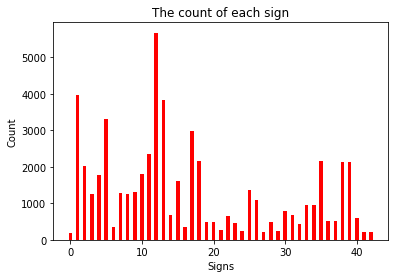

[ 0  0  0 ... 42 42 42]


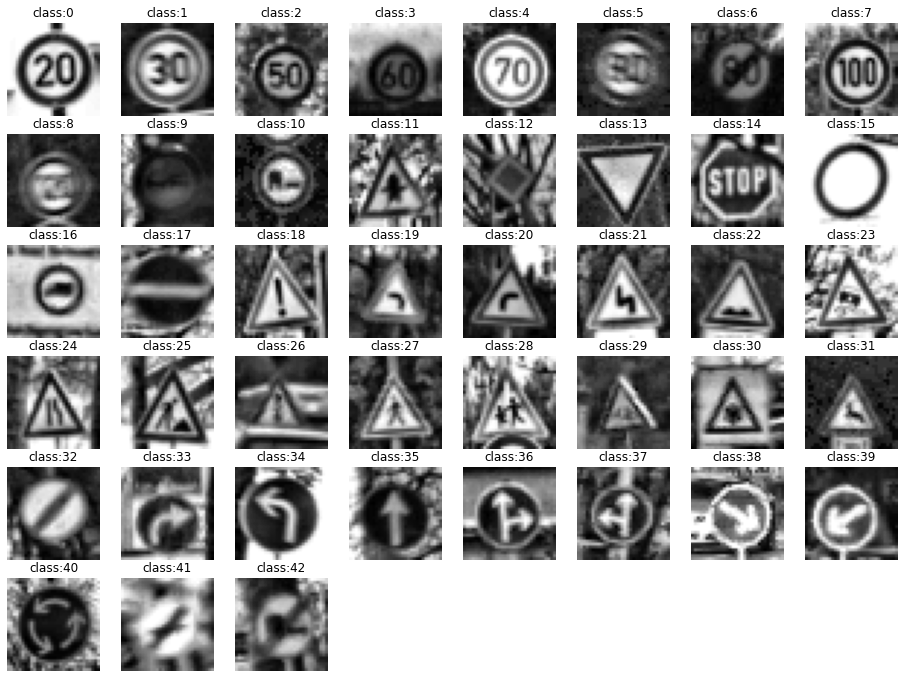

In [ ]:

# Data exploration visualization

fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(train_dataset.labels), 0.5, color = 'r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()
print(train_dataset.labels)
plt.figure(figsize= (16, 16))
temp =train_dataset.labels

for c in range(n_classes):

  i = random.choice(np.where(temp == c)[0])
  plt.subplot(8, 8, c+1)
  plt.axis('off')
  plt.title('class:{}'.format(c))
  plt.imshow(train_dataset.features[i].squeeze(), cmap = 'gray')


In [ ]:

model = BaselineNet(gray = True).to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum= 0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)


[Epoch 1/20] Train loss: 3.508851	Validation loss: 3.620194	 Validation accruacy: 4.762%
[Epoch 2/20] Train loss: 3.088647	Validation loss: 2.744402	 Validation accruacy: 26.848%
[Epoch 3/20] Train loss: 1.614434	Validation loss: 1.387473	 Validation accruacy: 61.134%
[Epoch 4/20] Train loss: 0.877720	Validation loss: 0.894868	 Validation accruacy: 73.492%
[Epoch 5/20] Train loss: 0.609169	Validation loss: 0.714602	 Validation accruacy: 79.274%
[Epoch 6/20] Train loss: 0.458692	Validation loss: 0.557595	 Validation accruacy: 83.719%
[Epoch 7/20] Train loss: 0.369091	Validation loss: 0.489703	 Validation accruacy: 85.601%
[Epoch 8/20] Train loss: 0.308059	Validation loss: 0.459977	 Validation accruacy: 87.143%
[Epoch 9/20] Train loss: 0.259753	Validation loss: 0.413591	 Validation accruacy: 87.574%
[Epoch 10/20] Train loss: 0.224300	Validation loss: 0.379378	 Validation accruacy: 89.796%
[Epoch 11/20] Train loss: 0.197360	Validation loss: 0.340532	 Validation accruacy: 89.751%
[Epoch 12

In [ ]:
#Augmentation #데이터 늘리기
train_dataset = extend_dataset(PickledDataset(training_file))
class_sample_count = np.bincount(train_dataset.labels) #숫자 분포  빈도수 체크
weights = 1 / np.array([class_sample_count[y] for y in train_dataset.labels])
samp = sampler.WeightedRandomSampler(weights, 43*20000)
train_loader = WrappendDataLoader(DataLoader(train_dataset, batch_size=64, sampler= samp), to_device)

[]


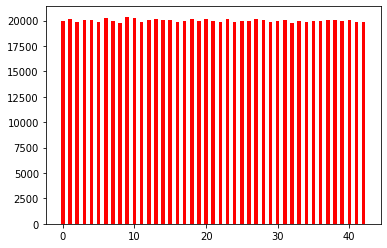

In [ ]:
balanced_y_train = torch.LongTensor([]).to(device)

with torch.no_grad():
  for  _, y in train_loader:
    balanced_y_train = torch.cat((balanced_y_train, y))
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(balanced_y_train.cpu().numpy()), 0.5, color = 'r')
plt.show()

In [ ]:
train_data_transforms = transforms.Compose([
      transforms.ToPILImage(), 
      transforms.RandomApply([
          transforms.RandomRotation(20, resample= PIL.Image.BICUBIC),
          transforms.RandomAffine(0, translate=(0.2, 0.2), resample=PIL.Image.BICUBIC), 
          transforms.RandomAffine(0, shear = 20, resample=PIL.Image.BICUBIC),
          transforms.RandomAffine(0, scale=(0.8, 1.2), resample=PIL.Image.BICUBIC)
      ]),
      transforms.ToTensor()                                           
])



test_data_transforms = transforms.ToTensor()
train_dataset = PickledDataset(training_file, transform =data_transforms )
valid_dataset = PickledDataset(validation_file, transform = data_transforms)
test_dataset = PickledDataset(testing_file, transform = data_transforms)

train_loader = WrappendDataLoader(DataLoader(train_dataset, batch_size = 64, shuffle = True), to_device)
valid_loader = WrappendDataLoader(DataLoader(valid_dataset, batch_size = 64, shuffle = False),to_device)
test_loader = WrappendDataLoader(DataLoader(test_dataset, batch_size = 64, shuffle = False),to_device)




/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1362: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [ ]:
def convert_image_np(img):
  img = img.numpy().transpose((1, 2, 0)).squeeze()
  return img

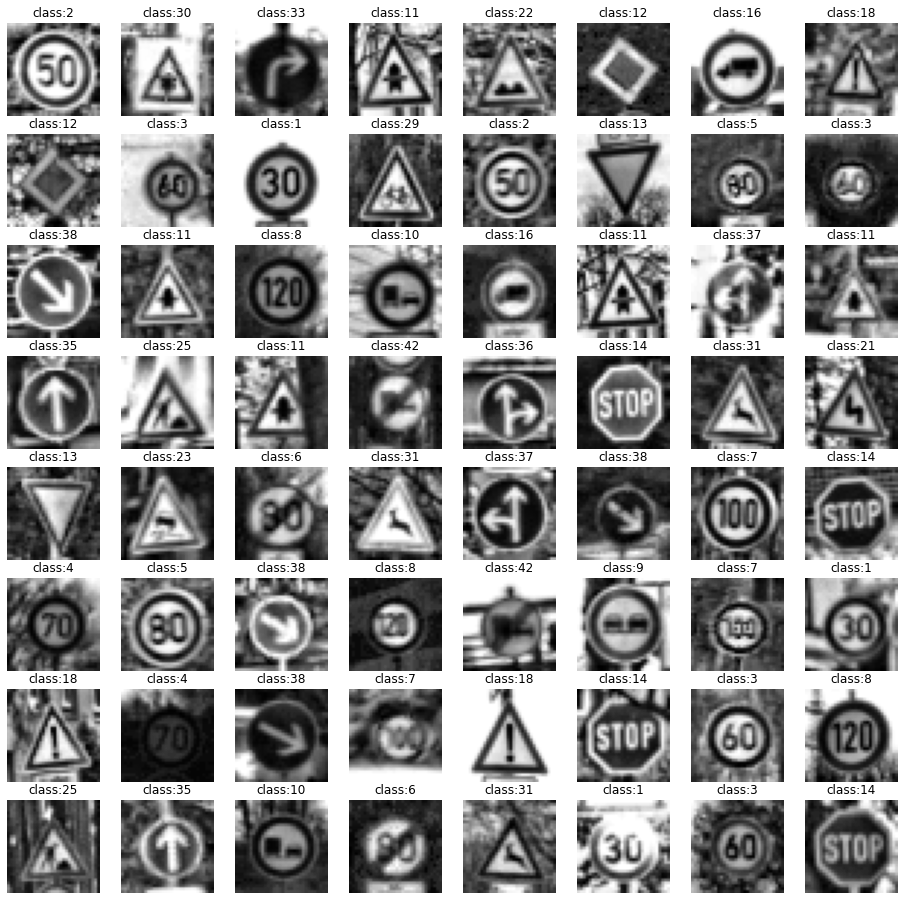

In [ ]:
with torch.no_grad():
  x, y = next(iter(train_loader))
  plt.figure(figsize= (16, 16))
  for i in range(len(y)):
    plt.subplot(8, 8, i+1)
    plt.axis('off')
    plt.title('class:{}'.format(y[i]))
    plt.imshow(convert_image_np(x[i].cpu()), cmap = 'gray')

In [ ]:
model = BaselineNet(gray= True).to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.696989	Validation loss: 3.586548	 Validation accruacy: 5.442%
[Epoch 2/20] Train loss: 3.484689	Validation loss: 3.558875	 Validation accruacy: 8.957%
[Epoch 3/20] Train loss: 3.459234	Validation loss: 3.528175	 Validation accruacy: 9.909%
[Epoch 4/20] Train loss: 3.348436	Validation loss: 3.225470	 Validation accruacy: 19.206%
[Epoch 5/20] Train loss: 2.546166	Validation loss: 2.047222	 Validation accruacy: 43.968%
[Epoch 6/20] Train loss: 1.490679	Validation loss: 1.338155	 Validation accruacy: 58.798%
[Epoch 7/20] Train loss: 0.982225	Validation loss: 0.945308	 Validation accruacy: 71.678%
[Epoch 8/20] Train loss: 0.731570	Validation loss: 0.700268	 Validation accruacy: 79.909%
[Epoch 9/20] Train loss: 0.589491	Validation loss: 0.649916	 Validation accruacy: 80.476%
[Epoch 10/20] Train loss: 0.491650	Validation loss: 0.567555	 Validation accruacy: 82.313%
[Epoch 11/20] Train loss: 0.423516	Validation loss: 0.574202	 Validation accruacy: 82.268%
[Epoch 12/2

In [ ]:
#Model

class TrafficSignNet(nn.Module):
  def __init__(self):
    super(TrafficSignNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 100, 5)
    self.conv1_bn = nn.BatchNorm2d(100) # 정규화를 입력에 적용하여 평균 및 단위 분산이 0이 되고 네트워크 정확도를 높입니다.
    self.pool = nn.MaxPool2d(2, 2)
    
    self.conv2 = nn.Conv2d(100, 150, 3)
    self.conv2_bn = nn.BatchNorm2d(150)
    
    self.conv3 = nn.Conv2d(150, 250, 1)
    self.conv3_bn = nn.BatchNorm2d(250)


    self.fc1 = nn.Linear(250*3*3, 350)
    self.fc1_bn = nn.BatchNorm1d(350)
    
    self.fc2 = nn.Linear(350, 43)


    self.dropout = nn.Dropout(p = 0.5)



  def forward(self, x):
      x = self.pool(F.elu(self.conv1(x)))
      x = self.dropout(self.conv1_bn(x))
      x = self.pool(F.elu(self.conv2(x)))
      x = self.dropout(self.conv2_bn(x))
      x = self.pool(F.elu(self.conv3(x)))
      x = self.dropout(self.conv3_bn(x))
      x = x.view(-1, 250 * 3 * 3)
      x = F.elu(self.fc1(x))
      x = self.dropout(self.fc1_bn(x))
      x = self.fc2(x)
      return x

'''
  def forward(self, x):
    x = self.pool(F.elu(self.conv1(x))
    x = self.dropout(self.conv1_bn(x))

    x = self.pool(F.elu(self.conv2(x))
    x = self.dropout(self.conv2_bn(x))

    x = self.pool(F.elu(self.conv3(x))
    x = self.dropout(self.conv3_bn(x))
    
    x = x.view(-1, 250*3*3)
    x = F.elu(self.fc1(x))
    x = self.dropout(self.fc1_bn(x))
    x = self.fc2(x)


    return x 

'''

    



'\n  def forward(self, x):\n    x = self.pool(F.elu(self.conv1(x))\n    x = self.dropout(self.conv1_bn(x))\n\n    x = self.pool(F.elu(self.conv2(x))\n    x = self.dropout(self.conv2_bn(x))\n\n    x = self.pool(F.elu(self.conv3(x))\n    x = self.dropout(self.conv3_bn(x))\n    \n    x = x.view(-1, 250*3*3)\n    x = F.elu(self.fc1(x))\n    x = self.dropout(self.fc1_bn(x))\n    x = self.fc2(x)\n\n\n    return x \n\n'

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, patience = 10):
  wait = 0
  valid_loss_min = np.Inf


  for epoch in range(epochs):
      
      #Train model
      model.train()
      losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
      train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
      
      #Validation model
      model.eval()
      with torch.no_grad():
          losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
          valid_loss = np.sum(np.multiply(losses, nums) / np.sum(nums))
          valid_accuracy = np.sum(corrects) / np.sum(nums)*100
          print(f"[Epoch {epoch+1}/{epochs}] "
                f"Train loss: {train_loss:.6f}\t"
                f"Validation loss: {valid_loss:.6f}\t",
                f"Validation accruacy: {valid_accuracy:.3f}%")    
          
          # Savw model if validation loss has decreased 
          if valid_loss <= valid_loss_min:
            print(f"Validation loss decreased ({valid_loss_min:.6f} -->{valid_loss:.6f}  ).Saving model ...")
            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = valid_loss
            wait = 0
          else:
            wait += 1
            if wait>=  patience:
              print(f"Terminated Training for Early Stopping at Epoch{epoch+1} ")
              return 

In [ ]:
n_epochs = 10
model = TrafficSignNet().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)

[Epoch 1/10] Train loss: 2.278363	Validation loss: 1.310317	 Validation accruacy: 65.646%
Validation loss decreased (inf -->1.310317  ).Saving model ...
[Epoch 2/10] Train loss: 1.056152	Validation loss: 0.770591	 Validation accruacy: 79.048%
Validation loss decreased (1.310317 -->0.770591  ).Saving model ...
[Epoch 3/10] Train loss: 0.666005	Validation loss: 0.493185	 Validation accruacy: 85.986%
Validation loss decreased (0.770591 -->0.493185  ).Saving model ...
[Epoch 4/10] Train loss: 0.458484	Validation loss: 0.365943	 Validation accruacy: 89.773%
Validation loss decreased (0.493185 -->0.365943  ).Saving model ...
[Epoch 5/10] Train loss: 0.341064	Validation loss: 0.277531	 Validation accruacy: 92.245%
Validation loss decreased (0.365943 -->0.277531  ).Saving model ...
[Epoch 6/10] Train loss: 0.269469	Validation loss: 0.232090	 Validation accruacy: 93.401%
Validation loss decreased (0.277531 -->0.232090  ).Saving model ...
[Epoch 7/10] Train loss: 0.218387	Validation loss: 0.1891

In [ ]:
check_point = torch.load('model.pt', map_location= device)
model.load_state_dict(check_point)
evaluate(model, criterion, test_loader)

Test loss: 0.145402	Test accruacy: 95.629%


# 새 섹션